In [ ]:
# 本项目使用豆粕期货从2006年1月到2025年12月的数据，分析了豆粕期货的价格走势和相关因素。
# 通过使用 Polars 对原始数据进行高效处理，包括合约筛选、滚动合约标记、计算每日盈亏和累积 PnL，并生成交易信号。
# 策略以OI_ratio和failure direction为入场信号，结合NBar，TP和Structure exit退出，通过SL进行风险管理。
# SL根据TR来计算，并有多个参数可调节，改变入场实际和持仓时长以及仓位大小等等，以模拟不同的策略和风险需求。
# 该项目的代码使用了Python的pandas和Polars库进行数据处理和分析，并使用了matplotlib进行数据可视化。

In [ ]:
# 需要的库
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl

# 本来打算做一个classfication。先把这个文件放在一边，等以后需要的时候再回来完善。
import torch
import torch.nn as nn
import torch.optim as optim

# 制图用的库
import matplotlib.pyplot as plt

# GPU加速（如果有GPU的话）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
#   查看 polars 版本
print("polars version:", pl.__version__)

polars version: 1.34.0


In [7]:
#   读取文件夹下的所有 Excel 文件路径   （根据文件的路径修改）
folder = Path(r"H:\shanyi\desktop\LongTerm Strategy of Family member\Gaia learning\Quant")
file_paths = list(folder.glob("*.xlsx"))

In [8]:
#   定义函数读取多个 Excel 文件并合并成一个 DataFrame
def read_excels(file_paths):
    dfs = []
    for f in file_paths:
        df_i = pl.read_excel(f)
        df_i = df_i.with_columns(
            pl.lit(f.name if hasattr(f, "name") else str(f)).alias("source_file")
        )
        dfs.append(df_i)
    return pl.concat(dfs, how="vertical")
df = read_excels(file_paths)
df.head(5)

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""豆粕""","""m2401""","""20240102""","""3,810""","""3,859""","""3,760""","""3,770""","""3,910""","""3,785""","""-140""","""-125""","""2,052""","""10,928""","""-7,040""","""77,669,480""","""m_ftr (1).xlsx"""
"""豆粕""","""m2403""","""20240102""","""3,748""","""3,748""","""3,667""","""3,667""","""3,812""","""3,691""","""-145""","""-121""","""219,414""","""440,756""","""-29,042""","""8,099,620,120""","""m_ftr (1).xlsx"""
"""豆粕""","""m2405""","""20240102""","""3,290""","""3,294""","""3,234""","""3,248""","""3,343""","""3,258""","""-95""","""-85""","""1,769,916""","""2,859,210""","""91,254""","""57,669,870,160""","""m_ftr (1).xlsx"""
"""豆粕""","""m2407""","""20240102""","""3,288""","""3,288""","""3,222""","""3,235""","""3,324""","""3,254""","""-89""","""-70""","""82,092""","""957,180""","""-4,120""","""2,671,493,880""","""m_ftr (1).xlsx"""
"""豆粕""","""m2408""","""20240102""","""3,352""","""3,358""","""3,298""","""3,313""","""3,392""","""3,324""","""-79""","""-68""","""26,714""","""151,108""","""7,140""","""888,157,680""","""m_ftr (1).xlsx"""


In [9]:
#   数据清洗函数
def clean_df(df: pl.DataFrame) -> pl.DataFrame:
    num_cols = [
        '开盘价','最高价','最低价','收盘价','前结算价','结算价',
        '涨跌','涨跌1','成交量','持仓量变化','成交额','持仓量'
    ]

    df = (
        df
        .with_columns([
            pl.col(c)
              .cast(pl.Utf8)
              .str.replace_all(",", "")
              .cast(pl.Float64, strict=False)
              .alias(c)
            for c in num_cols
            if c in df.columns
        ])
        .with_columns(
            pl.col("交易日期")
              .cast(pl.Utf8)
              .str.strptime(pl.Date, format="%Y%m%d", strict=False)
              .alias("交易日期")
        )
        .sort(["合约名称", "交易日期"])
    )
    return df
df = clean_df(df)
df.head(10)

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""豆粕""","""m0601""",2006-01-04,2430.0,2430.0,2350.0,2430.0,2337.0,2410.0,93.0,73.0,256.0,538.0,-146.0,6.17e6,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-05,2410.0,2410.0,2390.0,2390.0,2410.0,2404.0,-20.0,-6.0,160.0,418.0,-120.0,3.8472e6,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-06,2381.0,2420.0,2381.0,2420.0,2404.0,2416.0,16.0,12.0,22.0,416.0,-2.0,531620.0,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-09,2380.0,2380.0,2380.0,2380.0,2416.0,2380.0,-36.0,-36.0,6.0,416.0,0.0,142800.0,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-10,2388.0,2497.0,2388.0,2497.0,2380.0,2465.0,117.0,85.0,14.0,406.0,-10.0,345220.0,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-11,2400.0,2495.0,2400.0,2490.0,2465.0,2445.0,25.0,-20.0,42.0,388.0,-18.0,1.027e6,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-12,2480.0,2500.0,2299.0,2299.0,2445.0,2479.0,-146.0,34.0,390.0,2.0,-386.0,9.67158e6,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-13,2600.0,2600.0,2331.0,2550.0,2479.0,2462.0,71.0,-17.0,10.0,0.0,-2.0,246240.0,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-16,0.0,0.0,0.0,2462.0,2462.0,2462.0,0.0,0.0,0.0,0.0,0.0,0.0,"""m_ftr (19).xlsx"""


In [10]:
#   按照交易日期升序、持仓量降序排序
d1=df.sort(["交易日期", "持仓量"], descending=[False, True])
d1

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx"""
"""豆粕""","""m0609""",2006-01-04,2454.0,2492.0,2449.0,2492.0,2397.0,2473.0,95.0,76.0,3282.0,3234.0,-364.0,8.117836e7,"""m_ftr (19).xlsx"""
"""豆粕""","""m0601""",2006-01-04,2430.0,2430.0,2350.0,2430.0,2337.0,2410.0,93.0,73.0,256.0,538.0,-146.0,6.17e6,"""m_ftr (19).xlsx"""
"""豆粕""","""m0608""",2006-01-04,2440.0,2474.0,2440.0,2474.0,2379.0,2456.0,95.0,77.0,438.0,524.0,-104.0,1.076118e7,"""m_ftr (19).xlsx"""
"""豆粕""","""m0603""",2006-01-04,2385.0,2445.0,2385.0,2435.0,2353.0,2429.0,82.0,76.0,602.0,314.0,-162.0,1.462414e7,"""m_ftr (19).xlsx"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2601""",2025-12-19,3049.0,3052.0,3022.0,3043.0,3054.0,3037.0,-11.0,-17.0,432106.0,597074.0,-177910.0,1.3124e10,"""m_ftr.xlsx"""
"""豆粕""","""m2609""",2025-12-19,2859.0,2859.0,2843.0,2852.0,2856.0,2850.0,-4.0,-6.0,52498.0,428928.0,12276.0,1.4964e9,"""m_ftr.xlsx"""
"""豆粕""","""m2608""",2025-12-19,2853.0,2853.0,2839.0,2848.0,2852.0,2845.0,-4.0,-7.0,5126.0,183558.0,-76.0,1.4585556e8,"""m_ftr.xlsx"""


In [11]:
#   查看数据基本信息
d1.describe()

statistic,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""38824""","""38824""","""38824""",38824.0,38824.0,38824.0,38824.0,38824.0,38824.0,38824.0,38824.0,38824.0,38824.0,38824.0,38824.0,"""38824"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,"""2015-12-26 16:00:47.475788""",2947.001855,2968.2772,2926.044869,3080.095585,3078.446528,3079.517515,1.649057,1.070987,253793.010251,396084.561199,185.960591,8.0605e9,null
"""std""",null,null,null,768.960893,775.957026,762.226483,445.270261,443.315487,444.469187,41.286942,34.508425,613250.406733,766720.263021,30798.420317,1.9847e10,null
"""min""","""豆粕""","""m0601""","""2006-01-04""",0.0,0.0,0.0,2030.0,2050.0,2050.0,-316.0,-454.0,0.0,0.0,-425272.0,0.0,"""m_ftr (1).xlsx"""
"""25%""",null,null,"""2010-12-28""",2757.0,2773.0,2740.0,2779.0,2779.0,2780.0,-17.0,-15.0,64.0,412.0,-224.0,1.89478e6,null
"""50%""",null,null,"""2015-12-25""",2999.0,3020.0,2978.0,3020.0,3019.0,3020.0,0.0,0.0,6110.0,17450.0,0.0,1.8392564e8,null
"""75%""",null,null,"""2020-12-18""",3347.0,3368.0,3325.0,3357.0,3356.0,3358.0,21.0,17.0,146448.0,382530.0,1104.0,4.5089e9,null
"""max""","""豆粕""","""m2612""","""2025-12-19""",5100.0,5150.0,5086.0,5100.0,5092.0,5092.0,287.0,368.0,7.651616e6,5.52601e6,559030.0,2.7746e11,"""m_ftr.xlsx"""


In [12]:
#   标记主力合约    
d2=d1.with_columns((pl.col("持仓量") == pl.col("持仓量").max().over(["商品名称", "交易日期"])).alias("is_main"))
d2

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true
"""豆粕""","""m0609""",2006-01-04,2454.0,2492.0,2449.0,2492.0,2397.0,2473.0,95.0,76.0,3282.0,3234.0,-364.0,8.117836e7,"""m_ftr (19).xlsx""",false
"""豆粕""","""m0601""",2006-01-04,2430.0,2430.0,2350.0,2430.0,2337.0,2410.0,93.0,73.0,256.0,538.0,-146.0,6.17e6,"""m_ftr (19).xlsx""",false
"""豆粕""","""m0608""",2006-01-04,2440.0,2474.0,2440.0,2474.0,2379.0,2456.0,95.0,77.0,438.0,524.0,-104.0,1.076118e7,"""m_ftr (19).xlsx""",false
"""豆粕""","""m0603""",2006-01-04,2385.0,2445.0,2385.0,2435.0,2353.0,2429.0,82.0,76.0,602.0,314.0,-162.0,1.462414e7,"""m_ftr (19).xlsx""",false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2601""",2025-12-19,3049.0,3052.0,3022.0,3043.0,3054.0,3037.0,-11.0,-17.0,432106.0,597074.0,-177910.0,1.3124e10,"""m_ftr.xlsx""",false
"""豆粕""","""m2609""",2025-12-19,2859.0,2859.0,2843.0,2852.0,2856.0,2850.0,-4.0,-6.0,52498.0,428928.0,12276.0,1.4964e9,"""m_ftr.xlsx""",false
"""豆粕""","""m2608""",2025-12-19,2853.0,2853.0,2839.0,2848.0,2852.0,2845.0,-4.0,-7.0,5126.0,183558.0,-76.0,1.4585556e8,"""m_ftr.xlsx""",false


In [13]:
#   标记换月
d3 = (
    d2.sort(["合约名称", "交易日期"])
    .with_columns(
        (
            pl.col("is_main").shift(1).over("合约名称").fill_null(False)
            & (~pl.col("is_main"))
        ).alias("_is_rollover_raw")
    )
    .with_columns(
        (
            # 同一合约内，只保留第一次 rollover
            (pl.col("_is_rollover_raw").cast(pl.Int32).cum_sum().over("合约名称") == 1)
            & pl.col("_is_rollover_raw")
        ).alias("is_rollover")
    )
    .drop("_is_rollover_raw")
)

d3.head(10)

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool
"""豆粕""","""m0601""",2006-01-04,2430.0,2430.0,2350.0,2430.0,2337.0,2410.0,93.0,73.0,256.0,538.0,-146.0,6.17e6,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-05,2410.0,2410.0,2390.0,2390.0,2410.0,2404.0,-20.0,-6.0,160.0,418.0,-120.0,3.8472e6,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-06,2381.0,2420.0,2381.0,2420.0,2404.0,2416.0,16.0,12.0,22.0,416.0,-2.0,531620.0,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-09,2380.0,2380.0,2380.0,2380.0,2416.0,2380.0,-36.0,-36.0,6.0,416.0,0.0,142800.0,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-10,2388.0,2497.0,2388.0,2497.0,2380.0,2465.0,117.0,85.0,14.0,406.0,-10.0,345220.0,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-11,2400.0,2495.0,2400.0,2490.0,2465.0,2445.0,25.0,-20.0,42.0,388.0,-18.0,1.027e6,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-12,2480.0,2500.0,2299.0,2299.0,2445.0,2479.0,-146.0,34.0,390.0,2.0,-386.0,9.67158e6,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-13,2600.0,2600.0,2331.0,2550.0,2479.0,2462.0,71.0,-17.0,10.0,0.0,-2.0,246240.0,"""m_ftr (19).xlsx""",false,false
"""豆粕""","""m0601""",2006-01-16,0.0,0.0,0.0,2462.0,2462.0,2462.0,0.0,0.0,0.0,0.0,0.0,0.0,"""m_ftr (19).xlsx""",false,false


In [14]:
#   查看换月合约统计信息，确保每个合约至多一个换月
rollover_contracts = (
    d3
    .filter(pl.col("is_rollover"))
    .group_by("合约名称")
    .agg(
        pl.len().alias("rollover_cnt"),
        pl.min("交易日期").alias("first_rollover_date"),
        pl.max("交易日期").alias("last_rollover_date"),
    )
    .sort((["rollover_cnt","first_rollover_date"]), descending=[True, False])
)

rollover_contracts


合约名称,rollover_cnt,first_rollover_date,last_rollover_date
str,u32,date,date
"""m0605""",1,2006-02-17,2006-02-17
"""m0609""",1,2006-05-11,2006-05-11
"""m0611""",1,2006-07-28,2006-07-28
"""m0701""",1,2006-10-19,2006-10-19
"""m0705""",1,2007-01-29,2007-01-29
…,…,…,…
"""m2409""",1,2024-08-07,2024-08-07
"""m2501""",1,2024-11-04,2024-11-04
"""m2505""",1,2025-03-27,2025-03-27


In [15]:
   
rollover_contracts.describe()

statistic,合约名称,rollover_cnt,first_rollover_date,last_rollover_date
str,str,f64,str,str
"""count""","""61""",61.0,"""61""","""61"""
"""null_count""","""0""",0.0,"""0""","""0"""
"""mean""",null,1.0,"""2015-10-13 08:39:20.655737""","""2015-10-13 08:39:20.655737"""
"""std""",null,0.0,null,null
"""min""","""m0605""",1.0,"""2006-02-17""","""2006-02-17"""
"""25%""",null,1.0,"""2010-07-19""","""2010-07-19"""
"""50%""",null,1.0,"""2015-11-20""","""2015-11-20"""
"""75%""",null,1.0,"""2020-11-02""","""2020-11-02"""
"""max""","""m2601""",1.0,"""2025-11-27""","""2025-11-27"""


In [16]:
d3.group_by(["is_rollover"]).len()

is_rollover,len
bool,u32
false,38763
true,61


In [17]:
d3.group_by(["合约名称"]).len()

合约名称,len
str,u32
"""m0601""",10
"""m0603""",45
"""m0605""",88
"""m0607""",128
"""m0608""",149
…,…
"""m2607""",108
"""m2608""",85
"""m2609""",64


In [18]:
#   标记换月段  
d4 = d3.with_columns((pl.col("合约名称") != pl.col("合约名称").shift(1).over("商品名称")).fill_null(True).cast(pl.Int32).cum_sum().alias("segment"))
d4.head(10)

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32
"""豆粕""","""m0601""",2006-01-04,2430.0,2430.0,2350.0,2430.0,2337.0,2410.0,93.0,73.0,256.0,538.0,-146.0,6.17e6,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-05,2410.0,2410.0,2390.0,2390.0,2410.0,2404.0,-20.0,-6.0,160.0,418.0,-120.0,3.8472e6,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-06,2381.0,2420.0,2381.0,2420.0,2404.0,2416.0,16.0,12.0,22.0,416.0,-2.0,531620.0,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-09,2380.0,2380.0,2380.0,2380.0,2416.0,2380.0,-36.0,-36.0,6.0,416.0,0.0,142800.0,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-10,2388.0,2497.0,2388.0,2497.0,2380.0,2465.0,117.0,85.0,14.0,406.0,-10.0,345220.0,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-11,2400.0,2495.0,2400.0,2490.0,2465.0,2445.0,25.0,-20.0,42.0,388.0,-18.0,1.027e6,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-12,2480.0,2500.0,2299.0,2299.0,2445.0,2479.0,-146.0,34.0,390.0,2.0,-386.0,9.67158e6,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-13,2600.0,2600.0,2331.0,2550.0,2479.0,2462.0,71.0,-17.0,10.0,0.0,-2.0,246240.0,"""m_ftr (19).xlsx""",false,false,1
"""豆粕""","""m0601""",2006-01-16,0.0,0.0,0.0,2462.0,2462.0,2462.0,0.0,0.0,0.0,0.0,0.0,0.0,"""m_ftr (19).xlsx""",false,false,1


In [19]:
#   计算前一日收盘价
d5 = d4.with_columns(pl.col("收盘价").shift(1).over("segment").alias("prev_close"))
d5

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64
"""豆粕""","""m0601""",2006-01-04,2430.0,2430.0,2350.0,2430.0,2337.0,2410.0,93.0,73.0,256.0,538.0,-146.0,6.17e6,"""m_ftr (19).xlsx""",false,false,1,null
"""豆粕""","""m0601""",2006-01-05,2410.0,2410.0,2390.0,2390.0,2410.0,2404.0,-20.0,-6.0,160.0,418.0,-120.0,3.8472e6,"""m_ftr (19).xlsx""",false,false,1,2430.0
"""豆粕""","""m0601""",2006-01-06,2381.0,2420.0,2381.0,2420.0,2404.0,2416.0,16.0,12.0,22.0,416.0,-2.0,531620.0,"""m_ftr (19).xlsx""",false,false,1,2390.0
"""豆粕""","""m0601""",2006-01-09,2380.0,2380.0,2380.0,2380.0,2416.0,2380.0,-36.0,-36.0,6.0,416.0,0.0,142800.0,"""m_ftr (19).xlsx""",false,false,1,2420.0
"""豆粕""","""m0601""",2006-01-10,2388.0,2497.0,2388.0,2497.0,2380.0,2465.0,117.0,85.0,14.0,406.0,-10.0,345220.0,"""m_ftr (19).xlsx""",false,false,1,2380.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2612""",2025-12-15,2954.0,2956.0,2880.0,2917.0,2898.0,2922.0,19.0,24.0,19456.0,4294.0,4294.0,5.6868974e8,"""m_ftr.xlsx""",false,false,168,null
"""豆粕""","""m2612""",2025-12-16,2917.0,2928.0,2905.0,2920.0,2922.0,2915.0,-2.0,-7.0,4168.0,5256.0,962.0,1.2153004e8,"""m_ftr.xlsx""",false,false,168,2917.0
"""豆粕""","""m2612""",2025-12-17,2920.0,2930.0,2916.0,2921.0,2915.0,2923.0,6.0,8.0,2668.0,5968.0,712.0,7.799012e7,"""m_ftr.xlsx""",false,false,168,2920.0


In [20]:
d5.group_by(["商品名称", "segment"]).agg(pl.col("合约名称").n_unique().alias("n_contract")).filter(pl.col("n_contract") > 1)

商品名称,segment,n_contract
str,i32,u32


In [21]:
#   过滤出主力合约和换月合约
d6=d5.filter(pl.col("is_main") | pl.col("is_rollover"))
d6.head(10)

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0
"""豆粕""","""m0605""",2006-01-11,2375.0,2380.0,2350.0,2360.0,2375.0,2365.0,-15.0,-10.0,580826.0,315060.0,-10470.0,1.3737e10,"""m_ftr (19).xlsx""",true,false,3,2389.0
"""豆粕""","""m0605""",2006-01-12,2340.0,2349.0,2326.0,2339.0,2365.0,2337.0,-26.0,-28.0,481392.0,315020.0,-40.0,1.1251e10,"""m_ftr (19).xlsx""",true,false,3,2360.0
"""豆粕""","""m0605""",2006-01-13,2308.0,2314.0,2290.0,2310.0,2337.0,2301.0,-27.0,-36.0,455408.0,319460.0,4440.0,1.0482e10,"""m_ftr (19).xlsx""",true,false,3,2339.0
"""豆粕""","""m0605""",2006-01-16,2319.0,2334.0,2312.0,2329.0,2301.0,2324.0,28.0,23.0,328152.0,326000.0,6540.0,7.6266e9,"""m_ftr (19).xlsx""",true,false,3,2310.0


In [22]:
d6.group_by(["is_rollover"]).len()

is_rollover,len
bool,u32
true,61
false,4853


In [23]:
d6.group_by(["合约名称"]).len()

合约名称,len
str,u32
"""m0605""",28
"""m0609""",55
"""m0611""",57
"""m0701""",55
"""m0705""",70
…,…
"""m2501""",57
"""m2505""",97
"""m2509""",87


In [24]:
#   计算真实波动幅度 TR = max(当日最高价 - 当日最低价, 当日最高价 - 前一日收盘价的绝对值, 当日最低价 - 前一日收盘价的绝对值)
d7 =d6.with_columns(pl.max_horizontal([pl.col("最高价") - pl.col("最低价"),(pl.col("最高价") - pl.col("prev_close")).abs(),(pl.col("最低价") - pl.col("prev_close")).abs(),]).alias("TR"))
d7

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0


In [25]:
#   过滤出换月段及其前后一天的数据
idx = pl.arange(0, d7.height)

out = (
    d7.with_row_index("idx")
     .filter(
         pl.col("is_rollover")
         | pl.col("is_rollover").shift(1).fill_null(False)
         | pl.col("is_rollover").shift(-1).fill_null(False)
     )
)

out

idx,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR
u32,str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64
26,"""豆粕""","""m0605""",2006-02-16,2294.0,2294.0,2275.0,2286.0,2287.0,2285.0,-1.0,-2.0,38586.0,186754.0,-7342.0,8.8172194e8,"""m_ftr (19).xlsx""",true,false,3,2289.0,19.0
27,"""豆粕""","""m0605""",2006-02-17,2294.0,2335.0,2290.0,2328.0,2285.0,2316.0,43.0,31.0,96248.0,172870.0,-13884.0,2.2294e9,"""m_ftr (19).xlsx""",false,true,3,2286.0,49.0
28,"""豆粕""","""m0609""",2006-02-17,2371.0,2425.0,2361.0,2420.0,2357.0,2400.0,63.0,43.0,522764.0,201002.0,60320.0,1.2551e10,"""m_ftr (19).xlsx""",true,false,6,2356.0,69.0
81,"""豆粕""","""m0609""",2006-05-10,2292.0,2309.0,2288.0,2295.0,2286.0,2298.0,9.0,12.0,93858.0,247024.0,-4064.0,2.1575e9,"""m_ftr (19).xlsx""",true,false,6,2299.0,21.0
82,"""豆粕""","""m0609""",2006-05-11,2289.0,2335.0,2283.0,2315.0,2298.0,2316.0,17.0,18.0,176824.0,223766.0,-23258.0,4.0961e9,"""m_ftr (19).xlsx""",false,true,6,2295.0,52.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4817,"""豆粕""","""m2509""",2025-08-01,2996.0,3022.0,2989.0,3010.0,3006.0,3004.0,4.0,-2.0,2.0326e6,2.792216e6,-38334.0,6.1077e10,"""m_ftr.xlsx""",false,true,158,3000.0,33.0
4818,"""豆粕""","""m2601""",2025-08-01,3038.0,3049.0,3024.0,3037.0,3041.0,3035.0,-4.0,-6.0,973620.0,2.887002e6,105738.0,2.9556e10,"""m_ftr.xlsx""",true,false,161,3036.0,25.0
4895,"""豆粕""","""m2601""",2025-11-26,3010.0,3033.0,3006.0,3015.0,3009.0,3021.0,6.0,12.0,1.337468e6,2.807158e6,-99340.0,4.0413e10,"""m_ftr.xlsx""",true,false,161,3013.0,27.0


In [26]:
#   计算换月段的失败率指标
d8 = d7.with_columns([
    pl.min_horizontal([pl.col("最低价"), pl.col("prev_close")]).alias("tr_low"),
    pl.max_horizontal([pl.col("最高价"), pl.col("prev_close")]).alias("tr_high"),
    ]).with_columns([
    # up_failure
    pl.when(
        pl.col("is_rollover") | pl.col("TR").is_null() | (pl.col("TR") <= 0)
    )
    .then(None)
    .otherwise(
        ((pl.col("tr_high") - pl.col("收盘价")) / pl.col("TR")).clip(0, 1)
    )
    .alias("up_failure"),

    # down_failure
    pl.when(
        pl.col("is_rollover") | pl.col("TR").is_null() | (pl.col("TR") <= 0)
    )
    .then(None)
    .otherwise(
        ((pl.col("收盘价") - pl.col("tr_low")) / pl.col("TR")).clip(0, 1)
    )
    .alias("down_failure"),

    # failure_dir = up - down
    pl.when(
        pl.col("is_rollover") | pl.col("TR").is_null() | (pl.col("TR") <= 0)
    )
    .then(None)
    .otherwise(
        (
            ((pl.col("tr_high") - pl.col("收盘价")) / pl.col("TR")).clip(0, 1)
            -
            ((pl.col("收盘价") - pl.col("tr_low")) / pl.col("TR")).clip(0, 1)
        )
    )
    .alias("failure_dir"),
])
d8

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0,2375.0,2412.0,0.0,1.0,-1.0
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0,2405.0,2440.0,0.171429,0.828571,-0.657143
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0,2386.0,2444.0,0.103448,0.896552,-0.793103
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0,2365.0,2438.0,0.630137,0.369863,0.260274
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0,2360.0,2392.0,0.09375,0.90625,-0.8125
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0,2753.0,2772.0,0.736842,0.263158,0.473684
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0,2748.0,2780.0,0.09375,0.90625,-0.8125
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0,2752.0,2784.0,0.875,0.125,0.75


In [27]:
#   计算换月段的持仓量变化率指标 OI_ratio = 持仓量变化 / 成交量
d9 = (
    d8
    .with_columns(
        pl.col("持仓量").diff().over("segment").alias("dOI")
    )
    .with_columns(
        pl.when(
            pl.col("is_rollover")                      
            | pl.col("dOI").is_null()
            | pl.col("成交量").is_null()
            | (pl.col("成交量") <= 0)
        )
        .then(None)
        .otherwise(pl.col("dOI") / pl.col("成交量"))
        .alias("OI_ratio")
    )
)
d9

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0,2375.0,2412.0,0.0,1.0,-1.0,null,null
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0,2405.0,2440.0,0.171429,0.828571,-0.657143,17394.0,0.023407
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0,2386.0,2444.0,0.103448,0.896552,-0.793103,44594.0,0.063189
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0,2365.0,2438.0,0.630137,0.369863,0.260274,5538.0,0.006734
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0,2360.0,2392.0,0.09375,0.90625,-0.8125,-938.0,-0.00169
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0,2753.0,2772.0,0.736842,0.263158,0.473684,78190.0,0.050213
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0,2748.0,2780.0,0.09375,0.90625,-0.8125,89116.0,0.042903
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0,2752.0,2784.0,0.875,0.125,0.75,93504.0,0.058541


In [28]:
#   计算换月段的 CLV 指标 CLV = (收盘价*2 - 最低价 - 最高价) / (最高价 - 最低价)
d10 = d9.with_columns(
    ((pl.col("收盘价")*2-pl.col("最低价")-pl.col("最高价"))/(pl.col("最高价")-pl.col("最低价"))).fill_null(1.0).alias("CLV")
)
d10

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0,2375.0,2412.0,0.0,1.0,-1.0,null,null,1.0
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0,2405.0,2440.0,0.171429,0.828571,-0.657143,17394.0,0.023407,0.657143
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0,2386.0,2444.0,0.103448,0.896552,-0.793103,44594.0,0.063189,0.793103
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0,2365.0,2438.0,0.630137,0.369863,0.260274,5538.0,0.006734,0.102041
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0,2360.0,2392.0,0.09375,0.90625,-0.8125,-938.0,-0.00169,0.8125
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0,2753.0,2772.0,0.736842,0.263158,0.473684,78190.0,0.050213,-0.473684
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0,2748.0,2780.0,0.09375,0.90625,-0.8125,89116.0,0.042903,0.8125
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0,2752.0,2784.0,0.875,0.125,0.75,93504.0,0.058541,-0.75


In [29]:
#   过滤出换月段的交易日期和开盘价
xn = d10.filter(
    pl.col("is_rollover")
).select(
    pl.col("交易日期"),
    pl.col("开盘价").alias("old_open")
)
xn

交易日期,old_open
date,f64
2006-02-17,2294.0
2006-05-11,2289.0
2006-07-28,2213.0
2006-10-19,2275.0
2007-01-29,2440.0
…,…
2024-08-07,3031.0
2024-11-04,2970.0
2025-03-27,2824.0


In [30]:
#   将新开盘价合并回主 DataFrame，换月的时候方便计算移仓换月的平仓和开仓价格
x1=d10.join(xn, on=["交易日期"], how="left").with_columns(
    pl.when(pl.col("is_main"))
        .then(pl.col("开盘价"))
        .otherwise(None)
        .alias("new_open")
)
x1

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV,old_open,new_open
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0,2375.0,2412.0,0.0,1.0,-1.0,null,null,1.0,null,2380.0
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0,2405.0,2440.0,0.171429,0.828571,-0.657143,17394.0,0.023407,0.657143,null,2413.0
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0,2386.0,2444.0,0.103448,0.896552,-0.793103,44594.0,0.063189,0.793103,null,2395.0
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0,2365.0,2438.0,0.630137,0.369863,0.260274,5538.0,0.006734,0.102041,null,2370.0
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0,2360.0,2392.0,0.09375,0.90625,-0.8125,-938.0,-0.00169,0.8125,null,2371.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0,2753.0,2772.0,0.736842,0.263158,0.473684,78190.0,0.050213,-0.473684,null,2759.0
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0,2748.0,2780.0,0.09375,0.90625,-0.8125,89116.0,0.042903,0.8125,null,2763.0
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0,2752.0,2784.0,0.875,0.125,0.75,93504.0,0.058541,-0.75,null,2774.0


In [31]:
#   查看换月段的交易日期、原开盘价和新开盘价，确保合并正确
x1.filter(pl.col("old_open").is_not_null())

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV,old_open,new_open
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-02-17,2294.0,2335.0,2290.0,2328.0,2285.0,2316.0,43.0,31.0,96248.0,172870.0,-13884.0,2.2294e9,"""m_ftr (19).xlsx""",false,true,3,2286.0,49.0,2286.0,2335.0,null,null,null,-13884.0,null,0.688889,2294.0,null
"""豆粕""","""m0609""",2006-02-17,2371.0,2425.0,2361.0,2420.0,2357.0,2400.0,63.0,43.0,522764.0,201002.0,60320.0,1.2551e10,"""m_ftr (19).xlsx""",true,false,6,2356.0,69.0,2356.0,2425.0,0.072464,0.927536,-0.855072,null,null,0.84375,2294.0,2371.0
"""豆粕""","""m0609""",2006-05-11,2289.0,2335.0,2283.0,2315.0,2298.0,2316.0,17.0,18.0,176824.0,223766.0,-23258.0,4.0961e9,"""m_ftr (19).xlsx""",false,true,6,2295.0,52.0,2283.0,2335.0,null,null,null,-23258.0,null,0.230769,2289.0,null
"""豆粕""","""m0611""",2006-05-11,2371.0,2433.0,2369.0,2404.0,2384.0,2408.0,20.0,24.0,832848.0,286954.0,72640.0,2.0061e10,"""m_ftr (19).xlsx""",true,false,7,2382.0,64.0,2369.0,2433.0,0.453125,0.546875,-0.09375,null,null,0.09375,2289.0,2371.0
"""豆粕""","""m0611""",2006-07-28,2213.0,2215.0,2197.0,2205.0,2216.0,2205.0,-11.0,-11.0,33528.0,159692.0,-728.0,7.3955476e8,"""m_ftr (19).xlsx""",false,true,7,2213.0,18.0,2197.0,2215.0,null,null,null,-728.0,null,-0.111111,2213.0,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2509""",2025-03-27,2944.0,2955.0,2928.0,2948.0,2954.0,2942.0,-6.0,-12.0,864392.0,3.46775e6,66694.0,2.5437e10,"""m_ftr.xlsx""",true,false,158,2939.0,27.0,2928.0,2955.0,0.259259,0.740741,-0.481481,null,null,0.481481,2824.0,2944.0
"""豆粕""","""m2509""",2025-08-01,2996.0,3022.0,2989.0,3010.0,3006.0,3004.0,4.0,-2.0,2.0326e6,2.792216e6,-38334.0,6.1077e10,"""m_ftr.xlsx""",false,true,158,3000.0,33.0,2989.0,3022.0,null,null,null,-38334.0,null,0.272727,2996.0,null
"""豆粕""","""m2601""",2025-08-01,3038.0,3049.0,3024.0,3037.0,3041.0,3035.0,-4.0,-6.0,973620.0,2.887002e6,105738.0,2.9556e10,"""m_ftr.xlsx""",true,false,161,3036.0,25.0,3024.0,3049.0,0.48,0.52,-0.04,null,null,0.04,2996.0,3038.0


In [32]:
x1.filter(pl.col("new_open").is_not_null())

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV,old_open,new_open
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0,2375.0,2412.0,0.0,1.0,-1.0,null,null,1.0,null,2380.0
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0,2405.0,2440.0,0.171429,0.828571,-0.657143,17394.0,0.023407,0.657143,null,2413.0
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0,2386.0,2444.0,0.103448,0.896552,-0.793103,44594.0,0.063189,0.793103,null,2395.0
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0,2365.0,2438.0,0.630137,0.369863,0.260274,5538.0,0.006734,0.102041,null,2370.0
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0,2360.0,2392.0,0.09375,0.90625,-0.8125,-938.0,-0.00169,0.8125,null,2371.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0,2753.0,2772.0,0.736842,0.263158,0.473684,78190.0,0.050213,-0.473684,null,2759.0
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0,2748.0,2780.0,0.09375,0.90625,-0.8125,89116.0,0.042903,0.8125,null,2763.0
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0,2752.0,2784.0,0.875,0.125,0.75,93504.0,0.058541,-0.75,null,2774.0


In [33]:
#   标记换月新主力合约为is_rollover, 同时也是is_main, 因为换月当天新旧合约都交易，且新合约成为主力
x2=x1.with_columns(
    (
        (pl.col("合约名称").n_unique().over("交易日期") > 1)  # 同一天有多个合约
        | pl.col("is_rollover")  # 保留原来的 True
    ).alias("is_rollover")
)
x2

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV,old_open,new_open
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0,2375.0,2412.0,0.0,1.0,-1.0,null,null,1.0,null,2380.0
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0,2405.0,2440.0,0.171429,0.828571,-0.657143,17394.0,0.023407,0.657143,null,2413.0
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0,2386.0,2444.0,0.103448,0.896552,-0.793103,44594.0,0.063189,0.793103,null,2395.0
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0,2365.0,2438.0,0.630137,0.369863,0.260274,5538.0,0.006734,0.102041,null,2370.0
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0,2360.0,2392.0,0.09375,0.90625,-0.8125,-938.0,-0.00169,0.8125,null,2371.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0,2753.0,2772.0,0.736842,0.263158,0.473684,78190.0,0.050213,-0.473684,null,2759.0
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0,2748.0,2780.0,0.09375,0.90625,-0.8125,89116.0,0.042903,0.8125,null,2763.0
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0,2752.0,2784.0,0.875,0.125,0.75,93504.0,0.058541,-0.75,null,2774.0


In [34]:
#   查看换月段的交易日期、原开盘价和新开盘价，确保合并正确
x2.filter(pl.col("old_open").is_not_null())

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV,old_open,new_open
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-02-17,2294.0,2335.0,2290.0,2328.0,2285.0,2316.0,43.0,31.0,96248.0,172870.0,-13884.0,2.2294e9,"""m_ftr (19).xlsx""",false,true,3,2286.0,49.0,2286.0,2335.0,null,null,null,-13884.0,null,0.688889,2294.0,null
"""豆粕""","""m0609""",2006-02-17,2371.0,2425.0,2361.0,2420.0,2357.0,2400.0,63.0,43.0,522764.0,201002.0,60320.0,1.2551e10,"""m_ftr (19).xlsx""",true,true,6,2356.0,69.0,2356.0,2425.0,0.072464,0.927536,-0.855072,null,null,0.84375,2294.0,2371.0
"""豆粕""","""m0609""",2006-05-11,2289.0,2335.0,2283.0,2315.0,2298.0,2316.0,17.0,18.0,176824.0,223766.0,-23258.0,4.0961e9,"""m_ftr (19).xlsx""",false,true,6,2295.0,52.0,2283.0,2335.0,null,null,null,-23258.0,null,0.230769,2289.0,null
"""豆粕""","""m0611""",2006-05-11,2371.0,2433.0,2369.0,2404.0,2384.0,2408.0,20.0,24.0,832848.0,286954.0,72640.0,2.0061e10,"""m_ftr (19).xlsx""",true,true,7,2382.0,64.0,2369.0,2433.0,0.453125,0.546875,-0.09375,null,null,0.09375,2289.0,2371.0
"""豆粕""","""m0611""",2006-07-28,2213.0,2215.0,2197.0,2205.0,2216.0,2205.0,-11.0,-11.0,33528.0,159692.0,-728.0,7.3955476e8,"""m_ftr (19).xlsx""",false,true,7,2213.0,18.0,2197.0,2215.0,null,null,null,-728.0,null,-0.111111,2213.0,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2509""",2025-03-27,2944.0,2955.0,2928.0,2948.0,2954.0,2942.0,-6.0,-12.0,864392.0,3.46775e6,66694.0,2.5437e10,"""m_ftr.xlsx""",true,true,158,2939.0,27.0,2928.0,2955.0,0.259259,0.740741,-0.481481,null,null,0.481481,2824.0,2944.0
"""豆粕""","""m2509""",2025-08-01,2996.0,3022.0,2989.0,3010.0,3006.0,3004.0,4.0,-2.0,2.0326e6,2.792216e6,-38334.0,6.1077e10,"""m_ftr.xlsx""",false,true,158,3000.0,33.0,2989.0,3022.0,null,null,null,-38334.0,null,0.272727,2996.0,null
"""豆粕""","""m2601""",2025-08-01,3038.0,3049.0,3024.0,3037.0,3041.0,3035.0,-4.0,-6.0,973620.0,2.887002e6,105738.0,2.9556e10,"""m_ftr.xlsx""",true,true,161,3036.0,25.0,3024.0,3049.0,0.48,0.52,-0.04,null,null,0.04,2996.0,3038.0


In [35]:
#   过滤出主力合约，换月段的主力合约是新合约
d11=x2.filter(pl.col("is_main")!= False)
d11

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV,old_open,new_open
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0605""",2006-01-04,2380.0,2412.0,2375.0,2412.0,2320.0,2397.0,92.0,77.0,511524.0,258942.0,9984.0,1.2264e10,"""m_ftr (19).xlsx""",true,false,3,null,37.0,2375.0,2412.0,0.0,1.0,-1.0,null,null,1.0,null,2380.0
"""豆粕""","""m0605""",2006-01-05,2413.0,2440.0,2405.0,2434.0,2397.0,2422.0,37.0,25.0,743122.0,276336.0,17394.0,1.8004e10,"""m_ftr (19).xlsx""",true,false,3,2412.0,35.0,2405.0,2440.0,0.171429,0.828571,-0.657143,17394.0,0.023407,0.657143,null,2413.0
"""豆粕""","""m0605""",2006-01-06,2395.0,2444.0,2386.0,2438.0,2422.0,2418.0,16.0,-4.0,705728.0,320930.0,44594.0,1.7066e10,"""m_ftr (19).xlsx""",true,false,3,2434.0,58.0,2386.0,2444.0,0.103448,0.896552,-0.793103,44594.0,0.063189,0.793103,null,2395.0
"""豆粕""","""m0605""",2006-01-09,2370.0,2414.0,2365.0,2392.0,2418.0,2393.0,-26.0,-25.0,822360.0,326468.0,5538.0,1.9679e10,"""m_ftr (19).xlsx""",true,false,3,2438.0,73.0,2365.0,2438.0,0.630137,0.369863,0.260274,5538.0,0.006734,0.102041,null,2370.0
"""豆粕""","""m0605""",2006-01-10,2371.0,2392.0,2360.0,2389.0,2393.0,2375.0,-4.0,-18.0,554936.0,325530.0,-938.0,1.3181e10,"""m_ftr (19).xlsx""",true,false,3,2392.0,32.0,2360.0,2392.0,0.09375,0.90625,-0.8125,-938.0,-0.00169,0.8125,null,2371.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2605""",2025-12-15,2759.0,2772.0,2753.0,2758.0,2773.0,2762.0,-15.0,-11.0,1.557166e6,3.928414e6,78190.0,4.3019e10,"""m_ftr.xlsx""",true,false,163,2770.0,19.0,2753.0,2772.0,0.736842,0.263158,0.473684,78190.0,0.050213,-0.473684,null,2759.0
"""豆粕""","""m2605""",2025-12-16,2763.0,2780.0,2748.0,2777.0,2762.0,2763.0,15.0,1.0,2.077148e6,4.01753e6,89116.0,5.7411e10,"""m_ftr.xlsx""",true,false,163,2758.0,32.0,2748.0,2780.0,0.09375,0.90625,-0.8125,89116.0,0.042903,0.8125,null,2763.0
"""豆粕""","""m2605""",2025-12-17,2774.0,2784.0,2752.0,2756.0,2763.0,2766.0,-7.0,3.0,1.597242e6,4.111034e6,93504.0,4.4196e10,"""m_ftr.xlsx""",true,false,163,2777.0,32.0,2752.0,2784.0,0.875,0.125,0.75,93504.0,0.058541,-0.75,null,2774.0


In [36]:
#   查看换月段的交易日期、原开盘价和新开盘价，确保合并正确
d11.filter(pl.col("old_open").is_not_null())

商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file,is_main,is_rollover,segment,prev_close,TR,tr_low,tr_high,up_failure,down_failure,failure_dir,dOI,OI_ratio,CLV,old_open,new_open
str,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,bool,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""豆粕""","""m0609""",2006-02-17,2371.0,2425.0,2361.0,2420.0,2357.0,2400.0,63.0,43.0,522764.0,201002.0,60320.0,1.2551e10,"""m_ftr (19).xlsx""",true,true,6,2356.0,69.0,2356.0,2425.0,0.072464,0.927536,-0.855072,null,null,0.84375,2294.0,2371.0
"""豆粕""","""m0611""",2006-05-11,2371.0,2433.0,2369.0,2404.0,2384.0,2408.0,20.0,24.0,832848.0,286954.0,72640.0,2.0061e10,"""m_ftr (19).xlsx""",true,true,7,2382.0,64.0,2369.0,2433.0,0.453125,0.546875,-0.09375,null,null,0.09375,2289.0,2371.0
"""豆粕""","""m0701""",2006-07-28,2279.0,2289.0,2268.0,2278.0,2287.0,2277.0,-9.0,-10.0,240732.0,170744.0,19230.0,5.4830e9,"""m_ftr (19).xlsx""",true,true,9,2282.0,21.0,2268.0,2289.0,0.52381,0.47619,0.047619,null,null,-0.047619,2213.0,2279.0
"""豆粕""","""m0705""",2006-10-19,2382.0,2399.0,2377.0,2387.0,2383.0,2387.0,4.0,4.0,145438.0,131678.0,11256.0,3.4726e9,"""m_ftr (19).xlsx""",true,true,11,2368.0,31.0,2368.0,2399.0,0.387097,0.612903,-0.225806,null,null,-0.090909,2275.0,2382.0
"""豆粕""","""m0709""",2007-01-29,2582.0,2590.0,2572.0,2579.0,2577.0,2579.0,2.0,2.0,97058.0,142528.0,3920.0,2.5037e9,"""m_ftr (18).xlsx""",true,true,14,2574.0,18.0,2572.0,2590.0,0.611111,0.388889,0.222222,null,null,-0.222222,2440.0,2582.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""豆粕""","""m2501""",2024-08-07,3115.0,3125.0,3053.0,3065.0,3120.0,3086.0,-55.0,-34.0,1.350972e6,2.16868e6,171134.0,4.1697e10,"""m_ftr (1).xlsx""",true,true,153,3110.0,72.0,3053.0,3125.0,0.833333,0.166667,0.666667,null,null,-0.666667,3031.0,3115.0
"""豆粕""","""m2505""",2024-11-04,2822.0,2828.0,2800.0,2817.0,2827.0,2816.0,-10.0,-11.0,959542.0,3.160556e6,69748.0,2.7029e10,"""m_ftr (1).xlsx""",true,true,155,2821.0,28.0,2800.0,2828.0,0.392857,0.607143,-0.214286,null,null,0.214286,2970.0,2822.0
"""豆粕""","""m2509""",2025-03-27,2944.0,2955.0,2928.0,2948.0,2954.0,2942.0,-6.0,-12.0,864392.0,3.46775e6,66694.0,2.5437e10,"""m_ftr.xlsx""",true,true,158,2939.0,27.0,2928.0,2955.0,0.259259,0.740741,-0.481481,null,null,0.481481,2824.0,2944.0


In [37]:
import math
from typing import Optional, Dict, Any

# =========================================================
# 工具：价格按 tick 取整（按“对你不利”方向）
# =========================================================
def _round_to_tick(px: float, tick: float, mode: str) -> float:
    if tick is None or tick <= 0:
        return float(px)
    k = px / tick
    if mode == "floor":
        return math.floor(k) * tick
    if mode == "ceil":
        return math.ceil(k) * tick
    return round(k) * tick


def _apply_slip_and_tick(px: float, sgn: int, slip_bp: float, tick_size: float) -> float:
    """
    sgn = +1 买入（不利：上调）
    sgn = -1 卖出（不利：下调）
    """
    slip = slip_bp / 10000.0
    px2 = px * (1.0 + sgn * slip)
    if tick_size and tick_size > 0:
        px2 = _round_to_tick(px2, tick_size, "ceil" if sgn == +1 else "floor")
    return float(px2)


def _price_level_to_tick(px: float, tick_size: float, side: int) -> float:
    """
    对 SL/TP 价位落 tick（按不利方向）
    side=+1 多头平仓是卖出 -> 更低不利 -> floor
    side=-1 空头平仓是买回 -> 更高不利 -> ceil
    """
    if tick_size is None or tick_size <= 0:
        return float(px)
    return float(_round_to_tick(px, tick_size, "floor" if side == 1 else "ceil"))


# =========================================================
# 手续费模型：pct_notional + per_lot (+ min_fee_per_side)
# =========================================================
def _fee_one_side(notional: float, lots: int, fee_cfg: Dict[str, Any]) -> float:
    pct = float(fee_cfg.get("pct_notional", 0.0) or 0.0)
    per_lot = float(fee_cfg.get("per_lot", 0.0) or 0.0)
    min_fee = float(fee_cfg.get("min_fee_per_side", 0.0) or 0.0)

    fee = abs(notional) * pct + abs(lots) * per_lot
    if min_fee > 0:
        fee = max(fee, min_fee)
    return float(fee)

# =========================================================
# 退出侧：OI commitment（后半段背景） + volume_spike（努力） + CLV_fail（结果）
# =========================================================
def add_exit_features(
    d: pl.DataFrame,
    # OI commitment
    oi_ma_window: int = 5,
    oi_flat_th: float = 0.0,      # dOI_ma <= 0 => commit_off

    # volume spike（努力）
    vol_window: int = 60,
    vol_q: float = 0.90,
):
    x = d.sort("交易日期")

    # 分段 dOI（不跨合约）
    x = x.with_columns(
        pl.col("持仓量").diff().over("segment").alias("dOI_seg")
    )

    # 分段 dOI_ma
    x = x.with_columns(
        pl.col("dOI_seg")
          .rolling_mean(oi_ma_window, min_periods=oi_ma_window)
          .over("segment")
          .alias("dOI_ma")
    )

    x = x.with_columns([
        (pl.col("dOI_ma") > oi_flat_th).alias("oi_commit_on"),
        (pl.col("dOI_ma") <= oi_flat_th).alias("oi_commit_off"),
    ])

    # volume spike：用滚动分位（全局，不分段；更像“当下市场努力”）
    x = x.with_columns(
        pl.col("成交量")
          .rolling_quantile(quantile=vol_q, window_size=vol_window, min_samples=max(20, vol_window//3))
          .alias("vol_thr")
    ).with_columns(
        (pl.col("成交量") >= pl.col("vol_thr")).alias("volume_spike")
    )

    return x


# =========================================================
#  开仓信号（只用前两个因子）：OI_ratio + failure_dir
#    - gate: abs(OI_ratio) 进高分位（结构压力区）
#    - 方向：failure_dir 的符号
#    - 次日开盘执行（shift 1）
# =========================================================
def build_entry_signals_2factors(
    d: pl.DataFrame,
    gate_window: int = 252,
    q_gate: float = 0.90,
    fail_th: float = 0.30,
):
    x = d.sort("交易日期")

    x = x.with_columns(
        pl.col("OI_ratio").abs().alias("abs_OI")
    ).with_columns(
        pl.col("abs_OI")
          .rolling_quantile(quantile=q_gate, window_size=gate_window, min_samples=max(60, gate_window//4))
          .alias("gate_thr_abs")
    ).with_columns(
        (pl.col("abs_OI") >= pl.col("gate_thr_abs")).alias("gate_on")
    )

    valid = (
        (~pl.col("is_rollover"))
        & pl.col("OI_ratio").is_not_null()
        & pl.col("failure_dir").is_not_null()
        & pl.col("TR").is_not_null() & (pl.col("TR") > 0)
    )

    # 注意：你之前定义里 failure_dir = up - down
    # down 更大 => failure_dir 负 => 偏向多头（下方更“失败”）
    sig_long  = valid & pl.col("gate_on") & (pl.col("failure_dir") <= -fail_th)
    sig_short = valid & pl.col("gate_on") & (pl.col("failure_dir") >=  fail_th)

    x = x.with_columns([
        sig_long.shift(1).fill_null(False).alias("enter_long"),
        sig_short.shift(1).fill_null(False).alias("enter_short"),
    ])

    return x

# =========================================================
# 回测：rollover 改为“当日开盘旧平 + 新开（续仓）”
# =========================================================
def backtest_entry2_exit_struct_margin(
    d: pl.DataFrame,

    init_capital: float = 1_000_000.0,
    contract_multiplier: float = 10.0,
    margin_rate: float = 0.10,

    tick_size: float = 1.0,
    slip_bp: float = 0.0,

    fee_cfg: Optional[Dict[str, Any]] = None,

    tp_tr: float = 9.0,
    max_hold: int = 30,

    min_hold_for_struct: int = 5,
    mfe_tr: float = 3.0,
    clv_fail_th: float = 0.70,

    risk_per_trade: float = 0.01,
    max_margin_frac: float = 0.30,
    sl_tr: float = 2.0,

    max_drawdown_stop: float | None = None,
):
    if fee_cfg is None:
        fee_cfg = {"pct_notional": 0.0002, "per_lot": 0.0, "min_fee_per_side": 0.0}

    x = d.sort("交易日期")

    dates = x["交易日期"].to_list()
    o = x["开盘价"].to_list()
    h = x["最高价"].to_list()
    l = x["最低价"].to_list()
    c = x["收盘价"].to_list()
    tr = x["TR"].to_list()

    enter_long = x["enter_long"].to_list()
    enter_short = x["enter_short"].to_list()

    oi_commit_off = x["oi_commit_off"].to_list()
    volume_spike = x["volume_spike"].to_list()
    clv = x["CLV"].to_list()

    rollover = x["is_rollover"].to_list()

    # rollover 的旧/新开盘（必须有 old_open 才能真实 roll）
    old_open = x["old_open"].to_list() if "old_open" in x.columns else [None] * len(dates)
    new_open = x["new_open"].to_list() if "new_open" in x.columns else [None] * len(dates)

    # ===== 账户 =====
    equity = float(init_capital)
    peak_equity = float(init_capital)
    max_dd = 0.0

    # ===== 持仓 =====
    pos = 0
    size = 0
    entry_px = None
    entry_i = None
    entry_tr = None
    tp = None
    sl = None
    mfe = 0.0

    trades = []
    equity_curve = []

    for i in range(len(dates)):
        equity_curve.append((dates[i], equity))

        peak_equity = max(peak_equity, equity)
        dd = equity / peak_equity - 1.0
        max_dd = min(max_dd, dd)

        # ========= 持仓管理 =========
        if pos != 0:
            hold = i - entry_i

            # ====== 先处理 rollover：当天开盘 roll（旧平 + 新开），不算 exit trade ======
            if bool(rollover[i]):
                if old_open[i] is None:
                    # 没 old_open 无法真实 roll：可以选择 raise，让去补数据
                    raise ValueError(f"Missing old_open on rollover day: {dates[i]}")
                # 1) 旧合约：用旧合约当日开盘平仓
                old_exit_exec = _apply_slip_and_tick(
                    float(old_open[i]),
                    sgn=-pos,  # 多头卖出(-1)，空头买回(+1)
                    slip_bp=slip_bp,
                    tick_size=tick_size,
                )
                entry_exec = float(entry_px)

                notional_out = size * old_exit_exec * contract_multiplier
                fee_out = _fee_one_side(notional_out, size, fee_cfg)

                pnl_roll = (old_exit_exec - entry_exec) * pos * size * contract_multiplier - fee_out
                equity += pnl_roll

                # 2) 新合约：立刻用新合约当日开盘同方向开仓（new_open 没有就用主力面板 o[i]）
                new_level = float(new_open[i]) if new_open[i] is not None else float(o[i])
                new_entry_exec = _apply_slip_and_tick(
                    new_level,
                    sgn=pos,   # 多头买入(+1)，空头卖出(-1)
                    slip_bp=slip_bp,
                    tick_size=tick_size,
                )

                notional_in = size * new_entry_exec * contract_multiplier
                fee_in = _fee_one_side(notional_in, size, fee_cfg)
                equity -= fee_in

                # 3) 更新持仓锚点到新合约
                entry_px = new_entry_exec
                entry_i = i
                if tr[i] is not None and tr[i] > 0:
                    entry_tr = float(tr[i])

                # 重新设置 TP/SL（并落 tick）
                tp_raw = (new_entry_exec + tp_tr * entry_tr) if pos == 1 else (new_entry_exec - tp_tr * entry_tr)
                tp = _price_level_to_tick(tp_raw, tick_size, pos)

                if sl_tr and sl_tr > 0 and entry_tr is not None:
                    sl_dist = sl_tr * entry_tr
                    sl_raw = (new_entry_exec - sl_dist) if pos == 1 else (new_entry_exec + sl_dist)
                    sl = _price_level_to_tick(sl_raw, tick_size, pos)
                else:
                    sl = None

                mfe = 0.0
                hold = 0  # roll 后持仓天数从0开始（可选；不想重置就删这行）

            # ====== 更新 MFE（日内极值）=====
            if pos == 1:
                mfe = max(mfe, (h[i] - entry_px))
            else:
                mfe = max(mfe, (entry_px - l[i]))

            trend_established = (hold >= min_hold_for_struct) and   (entry_tr is not None and mfe >= mfe_tr * entry_tr)

            # CLV反向
            clv_fail = False
            if clv[i] is not None:
                if pos == 1 and (clv[i] <= -clv_fail_th):
                    clv_fail = True
                if pos == -1 and (clv[i] >=  clv_fail_th):
                    clv_fail = True

            struct_exit = (
                trend_established
                and (oi_commit_off[i] is True)
                and (volume_spike[i] is True)
                and clv_fail
            )

            # 日内触发：SL/TP（SL优先）
            hit_sl = False
            hit_tp = False

            if sl is not None:
                if pos == 1 and l[i] <= sl:
                    hit_sl = True
                if pos == -1 and h[i] >= sl:
                    hit_sl = True

            if tp is not None:
                if pos == 1 and h[i] >= tp:
                    hit_tp = True
                if pos == -1 and l[i] <= tp:
                    hit_tp = True

            reason = None
            exit_px_level = None

            # 注意：rollover 不再是 exit reason（因为已经在开盘 roll 过了）
            # 优先级：SL(日内) > TP(日内) > STRUCT_EXIT(收盘) > Nbar(收盘)
            if hit_sl:
                reason = "SL"
                exit_px_level = sl
            elif hit_tp:
                reason = "TP"
                exit_px_level = tp
            elif struct_exit:
                reason = "STRUCT_EXIT"
                exit_px_level = c[i]
            elif hold >= max_hold:
                reason = "Nbar"
                exit_px_level = c[i]

            if reason is not None:
                exit_px_level = float(exit_px_level)
                exit_exec = _apply_slip_and_tick(
                    exit_px_level,
                    sgn=-pos,  # 平仓方向
                    slip_bp=slip_bp,
                    tick_size=tick_size,
                )

                entry_exec = float(entry_px)

                notional_in = size * entry_exec * contract_multiplier
                notional_out = size * exit_exec * contract_multiplier
                fee = _fee_one_side(notional_in, size, fee_cfg) + _fee_one_side(notional_out, size, fee_cfg)

                pnl = (exit_exec - entry_exec) * pos * size * contract_multiplier - fee
                equity += pnl

                trades.append((
                    dates[entry_i], dates[i], int(pos), int(size),
                    float(entry_exec), float(exit_exec),
                    reason, float(pnl), int(hold)
                ))

                pos = 0
                size = 0
                entry_px = entry_i = entry_tr = tp = sl = None
                mfe = 0.0

        # ========= 开仓 =========
        if pos == 0:
            if max_drawdown_stop is not None:
                if (equity / peak_equity - 1.0) <= -abs(max_drawdown_stop):
                    continue

            go_long = bool(enter_long[i])
            go_short = bool(enter_short[i])

            if (go_long or go_short) and (tr[i] is not None) and (tr[i] > 0):
                pos = 1 if go_long else -1

                entry_exec = _apply_slip_and_tick(float(o[i]), sgn=pos, slip_bp=slip_bp, tick_size=tick_size)

                entry_px = entry_exec
                entry_i = i
                entry_tr = float(tr[i])

                tp_raw = (entry_exec + tp_tr * entry_tr) if pos == 1 else (entry_exec - tp_tr * entry_tr)
                tp = _price_level_to_tick(tp_raw, tick_size, pos)

                if sl_tr and sl_tr > 0:
                    sl_dist = sl_tr * entry_tr
                    sl_raw = (entry_exec - sl_dist) if pos == 1 else (entry_exec + sl_dist)
                    sl = _price_level_to_tick(sl_raw, tick_size, pos)
                else:
                    sl = None

                mfe = 0.0

                # ===== 仓位 sizing =====
                risk_dist = abs(entry_exec - sl) if (sl is not None) else 1.0 * entry_tr
                if risk_dist <= 0:
                    pos = 0
                    entry_px = entry_i = entry_tr = tp = sl = None
                    continue

                max_loss = equity * risk_per_trade
                size_risk = max_loss / (risk_dist * contract_multiplier)

                margin_per_lot = entry_exec * contract_multiplier * margin_rate
                if margin_per_lot <= 0:
                    pos = 0
                    entry_px = entry_i = entry_tr = tp = sl = None
                    continue

                size_margin = (equity * max_margin_frac) / margin_per_lot

                raw_size = min(size_risk, size_margin)
                size_int = int(math.floor(raw_size))
                if size_int <= 0:
                    pos = 0
                    entry_px = entry_i = entry_tr = tp = sl = None
                    continue

                size = size_int

                # 入场手续费（单边）
                notional_in = size * entry_exec * contract_multiplier
                fee_in = _fee_one_side(notional_in, size, fee_cfg)
                equity -= fee_in

    trades_df = pl.DataFrame(
        trades,
        schema=["entry_date","exit_date","side","size","entry_px","exit_px","reason","pnl","hold_days"]
    ) if len(trades) else pl.DataFrame(
        schema={
            "entry_date": pl.Date,
            "exit_date": pl.Date,
            "side": pl.Int8,
            "size": pl.Int32,
            "entry_px": pl.Float64,
            "exit_px": pl.Float64,
            "reason": pl.Utf8,
            "pnl": pl.Float64,
            "hold_days": pl.Int32,
        }
    )

    equity_df = pl.DataFrame(equity_curve, schema=["交易日期","equity"])

    stats = pl.DataFrame([{
        "init_capital": float(init_capital),
        "final_equity": float(equity_df["equity"][-1]) if equity_df.height else float(init_capital),
        "net_profit": float((equity_df["equity"][-1] if equity_df.height else init_capital) - init_capital),
        "n_trades": int(trades_df.height),
        "win_rate": float(trades_df.select((pl.col("pnl") > 0).mean()).item()) if trades_df.height else 0.0,
        "sum_pnl": float(trades_df.select(pl.col("pnl").sum()).item()) if trades_df.height else 0.0,
        "avg_pnl": float(trades_df.select(pl.col("pnl").mean()).item()) if trades_df.height else 0.0,
        "max_drawdown": float(max_dd),
        "tick_size": float(tick_size),
        "margin_rate": float(margin_rate),
        "fee_pct_notional": float(fee_cfg.get("pct_notional", 0.0) or 0.0),
        "fee_per_lot": float(fee_cfg.get("per_lot", 0.0) or 0.0),
        "min_fee_per_side": float(fee_cfg.get("min_fee_per_side", 0.0) or 0.0),
    }])

    return trades_df, equity_df, stats


# =========================================================
# 5) 一键跑回测函数（把上面所有步骤串起来）
# =========================================================
def run_backtest(
    d: pl.DataFrame,

    init_capital: float = 1_000_000.0,
    contract_multiplier: float = 10.0,
    margin_rate: float = 0.10,

    tick_size: float = 1.0,
    slip_bp: float = 0.0,

    fee_cfg: Optional[Dict[str, Any]] = None,

    tp_tr: float = 9.0,
    max_hold: int = 30,

    min_hold_for_struct: int = 5,
    mfe_tr: float = 3.0,
    clv_fail_th: float = 0.70,

    risk_per_trade: float = 0.01,
    max_margin_frac: float = 0.30,
    sl_tr: float = 2.0,

    max_drawdown_stop: float | None = None,
    
    
    # entry
    gate_window=252, q_gate=0.90, fail_th=0.30,
    # exit features
    oi_ma_window=5, oi_flat_th=0.0,
    vol_window=60, vol_q=0.90,
    # backtest
    
):
    d = d.clone()
    d = add_exit_features(
        d,
        oi_ma_window=oi_ma_window,
        oi_flat_th=oi_flat_th,
        vol_window=vol_window,
        vol_q=vol_q,
    )
    d = build_entry_signals_2factors(
        d,
        gate_window=gate_window,
        q_gate=q_gate,
        fail_th=fail_th,
    )
    trades, equity, stats = backtest_entry2_exit_struct_margin(
        d,
        init_capital = init_capital,
        contract_multiplier = contract_multiplier,
        margin_rate = margin_rate,

        tick_size = tick_size,
        slip_bp= slip_bp,

        fee_cfg = fee_cfg,

        tp_tr= tp_tr,
        max_hold= max_hold,

        min_hold_for_struct= min_hold_for_struct,
        mfe_tr = mfe_tr,
        clv_fail_th= clv_fail_th,

        risk_per_trade= risk_per_trade,
        max_margin_frac = max_margin_frac,
        sl_tr = sl_tr,

        max_drawdown_stop=max_drawdown_stop,
    )
    return d, trades, equity, stats

# =========================================================
# 用法（只要把 x 换成全表变量名）
# =========================================================

# 4) 跑回测
#   d, trades, equity, stats = run_backtest(
#     x,
#     init_capital=1_000_000,
#     contract_multiplier=10.0,
#     margin_rate=0.10,
#     tick_size=1.0,
#     slip_bp=0.0,
#     fee_cfg={"pct_notional": 0.0002, "per_lot": 0.0, "min_fee_per_side": 0.0},
#     tp_tr=9.0,
#     max_hold=30,
#     min_hold_for_struct=5,
#     mfe_tr=3.0,
#     clv_fail_th=0.70,
#     sl_tr=2.0,
#     risk_per_trade=0.01,
#     max_margin_frac=0.30,
#     max_drawdown_stop=None,
# )
# stats
# trades.head(20)


In [38]:
#  跑回测
df, trades, equity, stats = run_backtest(
    d11,
    init_capital=1_000_000,
    contract_multiplier=10.0,
     margin_rate=0.10,
     tick_size=1.0,
     slip_bp=0.0,
     fee_cfg={"pct_notional": 0.0000, "per_lot": 1.5, "min_fee_per_side": 0.0},
     tp_tr=5.0,
     max_hold=30,
     min_hold_for_struct=5,
     mfe_tr=3.0,
     clv_fail_th=0.7,
     risk_per_trade=0.02,
     max_margin_frac=0.50,
     max_drawdown_stop=None,
     sl_tr=0.03, 
     gate_window=252, q_gate=0.90, fail_th=0.30,
    # exit features
    oi_ma_window=5, oi_flat_th=0.0,
    vol_window=60, vol_q=0.90,
 )

stats

C:\Users\shanyi\AppData\Local\Temp\ipykernel_17836\1838213932.py:76: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col("dOI_seg")
d:\Users\shanyi\anaconda3\envs\torch-gpu\lib\functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


init_capital,final_equity,net_profit,n_trades,win_rate,sum_pnl,avg_pnl,max_drawdown,tick_size,margin_rate,fee_pct_notional,fee_per_lot,min_fee_per_side
f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1e6,5.1949e8,5.1849e8,323,0.058824,4.15123431e8,1.2852e6,-0.227012,1.0,0.1,0.0,1.5,0.0


In [39]:

#   查看交易明细
trades.sample(10)

entry_date,exit_date,side,size,entry_px,exit_px,reason,pnl,hold_days
date,date,i64,i64,f64,f64,str,f64,i64
2024-02-22,2024-02-23,-1,90013,2988.0,2989.0,"""SL""",-1.170169e6,1
2017-07-04,2017-07-05,1,12168,2792.0,2790.0,"""SL""",-279864.0,1
2022-06-20,2022-06-21,1,49655,4188.0,4185.0,"""SL""",-1.638615e6,1
2006-07-28,2006-07-28,-1,251,2279.0,2280.0,"""SL""",-3263.0,0
2025-02-05,2025-02-06,1,91969,2897.0,2893.0,"""SL""",-3.954667e6,1
2021-08-13,2021-08-16,-1,38359,3539.0,3543.0,"""SL""",-1.649437e6,1
2016-03-07,2016-03-08,1,9098,2338.0,2336.0,"""SL""",-209254.0,1
2015-03-02,2015-03-03,1,6695,2869.0,2868.0,"""SL""",-87035.0,1
2019-02-28,2019-03-01,-1,16866,2480.0,2481.0,"""SL""",-219258.0,1


In [40]:
#   统计不同平仓原因的交易数量
trades.group_by("reason").agg(pl.len().alias("n")).sort("n", descending=True)

reason,n
str,u32
"""SL""",304
"""TP""",13
"""STRUCT_EXIT""",4
"""Nbar""",2


In [41]:
#   统计不同平仓原因的盈亏情况
(
    trades
    .group_by("reason")
    .agg([
        pl.len().alias("n_trades"),
        pl.col("pnl").sum().alias("pnl_sum"),
        pl.col("pnl").mean().alias("pnl_mean"),
        pl.col("pnl").max().alias("pnl_max"),
        pl.col("pnl").min().alias("pnl_min"),
    ])
    .sort("pnl_sum", descending=True)
)

reason,n_trades,pnl_sum,pnl_mean,pnl_max,pnl_min
str,u32,f64,f64,f64,f64
"""TP""",13,4.46470199e8,3.4344e7,1.13475726e8,1.061907e6
"""STRUCT_EXIT""",4,1.46821795e8,3.6705e7,1.00611049e8,4.056698e6
"""Nbar""",2,5.759252e6,2.879626e6,3.881547e6,1.877705e6
"""SL""",304,-1.8393e8,-605025.707237,-3263.0,-3.954667e6


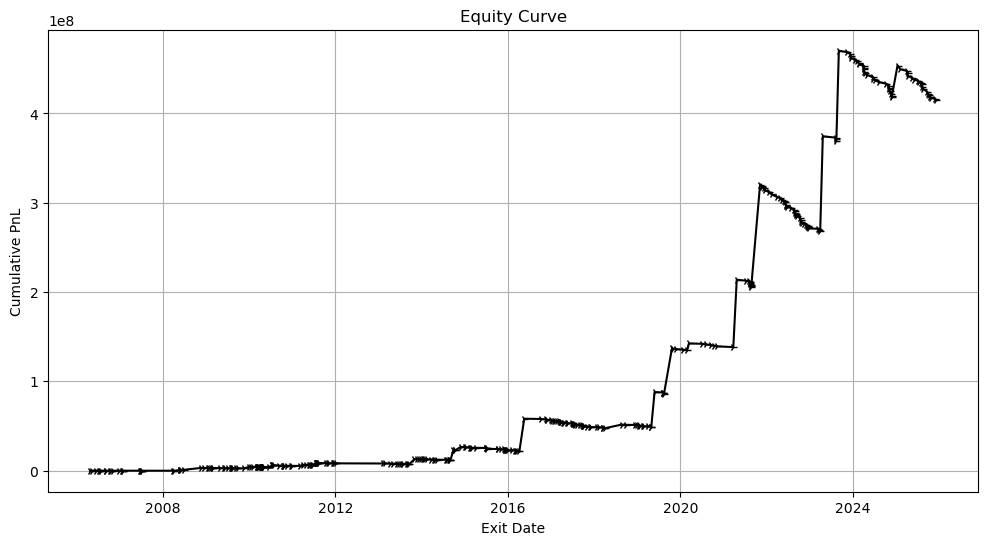

In [42]:
#   绘制盈亏分布图
# 1️⃣ 转 exit_date 为日期类型
t1 = trades.with_columns([
    pl.col("exit_date")
])

# 2️⃣ 按 exit_date 排序
t1 = t1.sort("exit_date")

# 3️⃣ 计算累积 PnL
t1 = t1.with_columns([
    pl.col("pnl").cum_sum().alias("cum_pnl")
])

# 4️⃣ 转 pandas 用于绘图
pdf = t1.to_pandas()

# 5️⃣ 绘制累积 PnL 曲线
plt.figure(figsize=(12,6))
plt.plot(pdf["exit_date"], pdf["cum_pnl"], marker="4", linestyle="-", color="black")

plt.xlabel("Exit Date")
plt.ylabel("Cumulative PnL")
plt.title("Equity Curve")
plt.grid(True)



plt.show()